<a href="https://www.kaggle.com/code/robertgrantham/austin-crime-reports-analysis?scriptVersionId=147867912" target="_blank"><img align="left" alt="Kaggle" title="Open in Kaggle" src="https://kaggle.com/static/images/open-in-kaggle.svg"></a>

# Analyzing Austin PD's Crime Reports Dataset

The Austin Police Department's Crime Reports dataset provides valuable information about reported crimes in Austin, Texas. In this analysis, we will explore the dataset and gain insights into various aspects of crime in Austin.

## Table of Contents

I. Introduction  
II. Data  
III. Methodology  
IV. Outcome  

## I. Introduction

The Austin Police Department's Crime Reports dataset offers a comprehensive view of reported crimes in Austin, Texas. By analyzing this dataset, we can extract valuable insights into the nature and patterns of crime in the city.

## II. Data

### 1. Project Context

This project is self-paced and not affiliated with any work or educational institution. My goal is to uncover valuable insights that can benefit the Austin law enforcement community, news outlets, and anyone interested in understanding and addressing crime-related issues in the Austin area.

### 2. Data Collection

Initially, I attempted to import the data into this notebook using Sodapy's Socrata API method. However, I found it to be insufficient as it didn't import the complete dataset and added redundant columns. As a result, I decided to manually download the entire dataset and repeat the process each week after the updates.

### 3. Data Scrubbing

Before conducting any analysis, it is crucial to clean and preprocess the dataset. The data scrubbing process involves addressing missing data, removing irrelevant columns, and ensuring data types are appropriate.

## III. Methodology

Once the dataset is scrubbed and prepared, we can perform an exploratory analysis to gain a deeper understanding of the crime data. The exploratory analysis may include the following:

### A. Crime Rates by Area

#### 1. Crime Rates by Zip Code

We start by examining the crime rates by zip code. The following code calculates the total number of crimes for each zip code and displays the top 10 zip codes with the highest crime rates.

```python
crime_by_zipcode = df["zip_code"].value_counts().head(10).to_frame()
display(crime_by_zipcode)
```

#### 2. Crime Rates as Percentages

In addition to the total crime counts, it is also informative to analyze the crime rates as percentages relative to the total. The following code calculates the crime rates as percentages for each zip code and displays the top 10 zip codes with the highest crime rates.

```python
crime_rates_by_zipcode = df["zip_code"].value_counts(normalize=True).head(10).to_frame()
display(crime_rates_by_zipcode)
```

#### 3. Visualizing Crime Rates by Zip Code

To visually represent the crime rates by zip code, we can create a bar chart. The following code generates a bar chart showing the top 10 zip codes with the highest crime rates.

```python
plt.figure(figsize=(10, 6))
crime_by_zipcode.plot(kind="bar", rot=45)
plt.title("Top 10 Zip Codes with Highest Crime Rates")
plt.xlabel("Zip Code")
plt.ylabel("Number of Crimes")
plt.show()
```

## IV. Outcome

In this section, we summarize the key findings and insights obtained from the analysis. Discuss any significant patterns, trends, or observations related to crime in Austin based on the data and methodologies applied.

By analyzing the crime data, we aim to contribute to a better understanding of crime distribution, trends, and areas of concern in Austin. This information can be valuable for law enforcement agencies, policymakers, and the community in efforts to address and prevent crime effectively.

In [1]:
import os
import pandas as pd
import matplotlib.pyplot as plt
import folium
from folium import plugins
from folium.plugins import FastMarkerCluster
from geopy.distance import geodesic
from sklearn.cluster import KMeans
import seaborn as sns
import warnings

# Create an output directory if it doesn't exist
OUTPUT_DIRECTORY = "crime_analysis_outputs"
os.makedirs(OUTPUT_DIRECTORY, exist_ok=True)

BOOKING_OFFICE_COORDS = (30.274020, -97.746580)  # Latitude, Longitude

# Redirect the output to a file
output_file = os.path.join(OUTPUT_DIRECTORY, "output.txt")
with open(output_file, "w") as output:
    print("Redirecting output to", output_file)
    print("Some Example Output", file=output)
# Set up pandas and seaborn
pd.set_option("display.max_columns", None)
warnings.filterwarnings("ignore")
plt.style.use("seaborn-white")
sns.set_style("whitegrid")


Redirecting output to crime_analysis_outputs/output.txt


In [2]:
def load_data(file_path):
    # Load data from a CSV file
    try:
        df = pd.read_csv(file_path)
        return df
    except Exception as e:
        print("Error loading data:", e)
        return None


def calculate_distance_to_booking_office(df):
    # Calculate the distance from each crime location to the booking office
    df = df.dropna(subset=["Latitude", "Longitude"])
    df["Distance to Booking Office (Miles)"] = df.apply(
        lambda row: geodesic(
            (row["Latitude"], row["Longitude"]), BOOKING_OFFICE_COORDS
        ).miles,
        axis=1,
    )
    return df


In [3]:
def clean_data(df):
    # Clean and preprocess the DataFrame
    columns_to_drop = [
        "X-coordinate",
        "Y-coordinate",
        "Location",
    ]
    df = df.drop(columns=columns_to_drop, errors="ignore")

    date_time_columns = ["Occurred Date Time", "Report Date Time", "Clearance Date"]
    for col in date_time_columns:
        df[col] = pd.to_datetime(df[col], errors="coerce")
    df.fillna(
        {
            "Zip Code": "Unknown",
            "Location Type": "Unknown",
            "Council District": "Unknown",
            "PRA": "Unknown",
            "Census Tract": "Unknown",
            "APD Sector": "Unknown",
            "APD District": "Unknown",
            "Clearance Status": "Unknown",
            "Category Description": "Unknown",
        },
        inplace=True,
    )

    categorical_columns = [
        "Highest Offense Description",
        "Zip Code",
        "Location Type",
        "Council District",
        "APD District",
        "APD Sector",
        "PRA",
        "Census Tract",
        "Category Description",
    ]
    df[categorical_columns] = df[categorical_columns].astype("category")

    df["Year"] = df["Occurred Date Time"].dt.year
    df["Quarter"] = df["Occurred Date Time"].dt.quarter
    df["Month"] = df["Occurred Date Time"].dt.month
    df["Day"] = df["Occurred Date Time"].dt.day
    df["Day of Week"] = df["Occurred Date Time"].dt.dayofweek

    day_of_week_dummies = pd.get_dummies(
        df["Day of Week"], prefix="Day", drop_first=True
    )
    df = pd.concat([df, day_of_week_dummies], axis=1)

    df.set_index("Occurred Date Time", inplace=True)
    df.sort_index(inplace=True)

    df["Time to Clearance (Days)"] = (
        df["Clearance Date"] - df["Report Date Time"]
    ).dt.days

    return df


In [4]:
def filter_and_save_data(df, filter_condition, filename):
    filtered_data = df.query(filter_condition)
    filtered_data.to_csv(filename, index=False)


def plot_bar_graph(data, x_label, y_label, title, filename):
    plt.figure(figsize=(12, 6))
    data.plot(kind="bar", rot=60)
    plt.title(title)
    plt.xlabel(x_label)
    plt.ylabel(y_label)
    plt.tight_layout()
    plt.savefig(filename)


def create_heatmap(df, outfile):
    coords_heat = df[["Latitude", "Longitude"]].dropna()
    map_austin = folium.Map(
        location=[30.2672, -97.7431], tiles="OpenStreetMap", zoom_start=12
    )
    map_austin.add_child(plugins.HeatMap(coords_heat.values, radius=15))
    map_austin.save(outfile)


def cluster_crime_locations(df, n_clusters):
    kmeans = KMeans(n_clusters=n_clusters, random_state=0)
    df["Location Cluster"] = kmeans.fit_predict(df[["Latitude", "Longitude"]])
    return df


The 'Occurred Date Time' column is not present in the dataset.


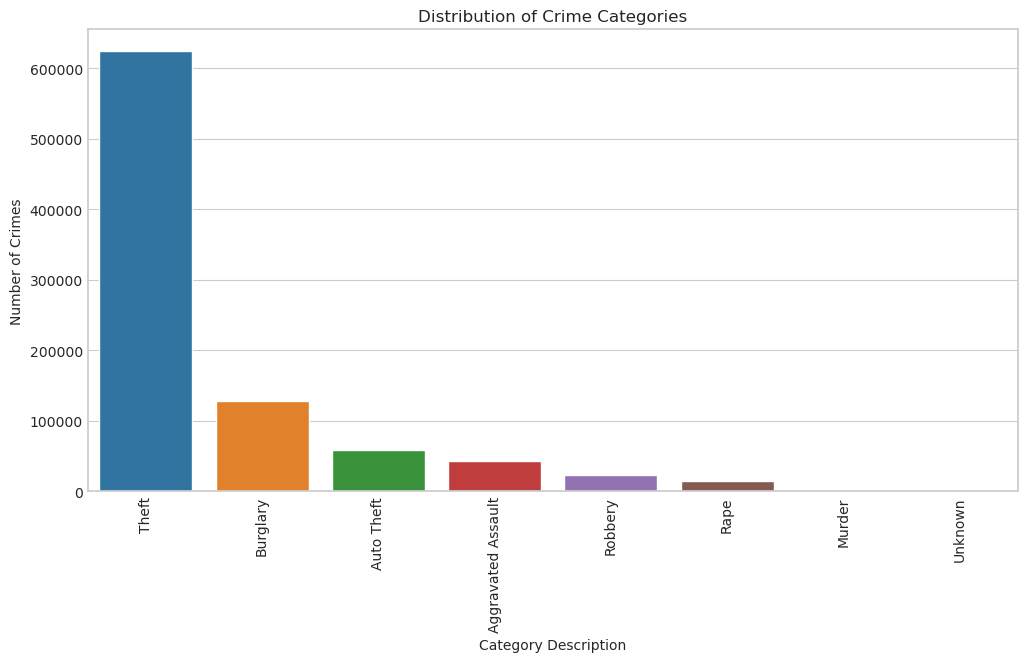

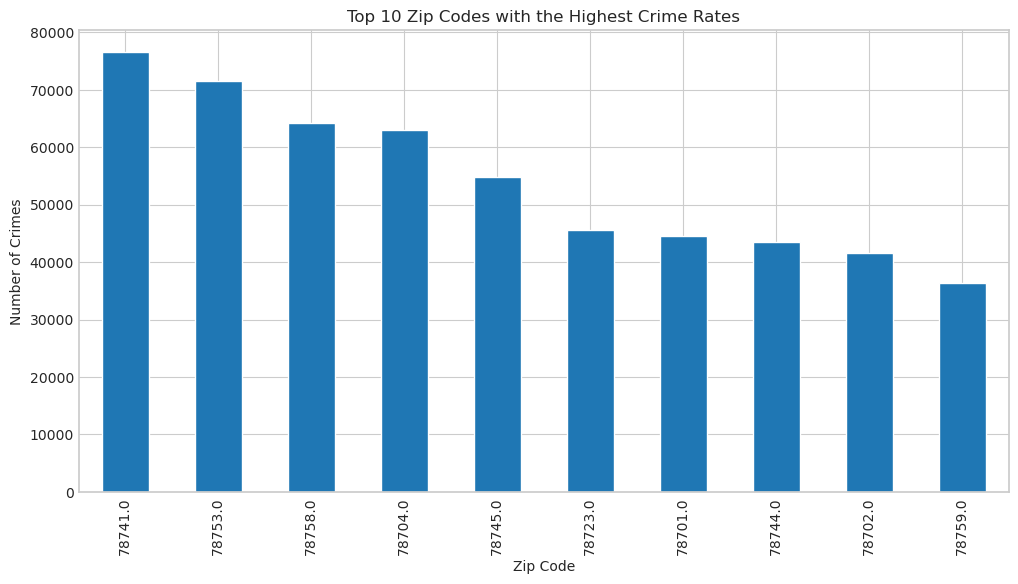

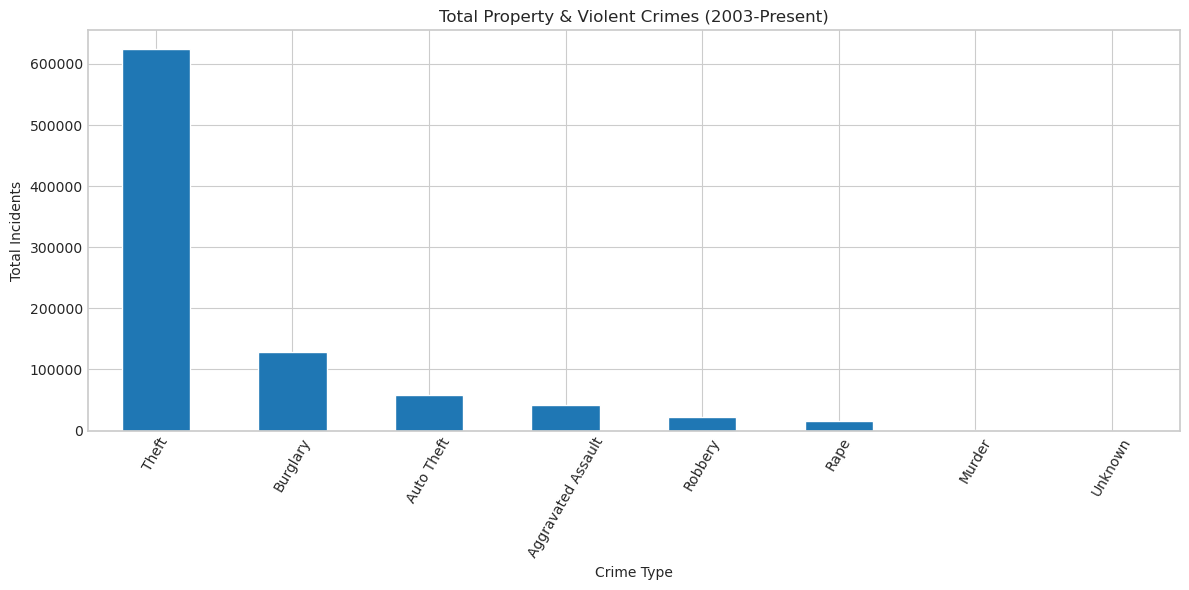

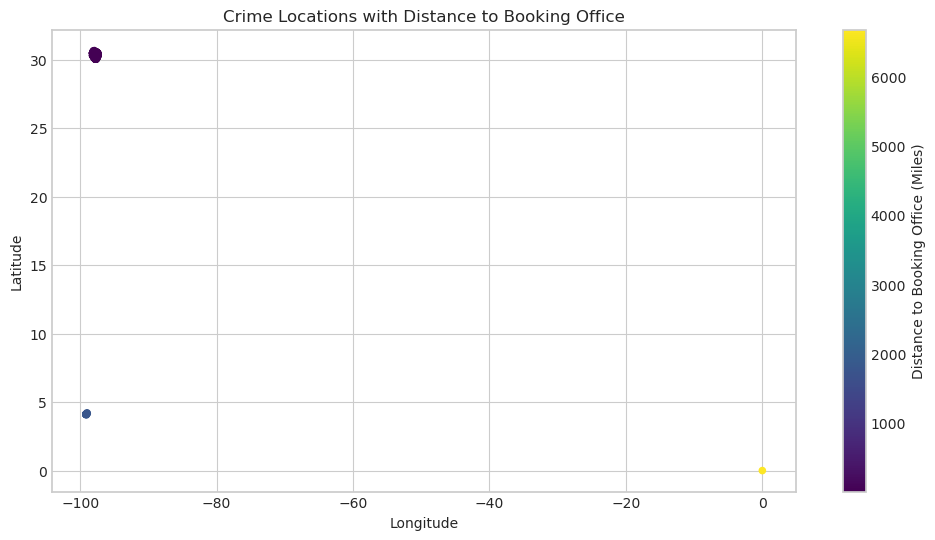

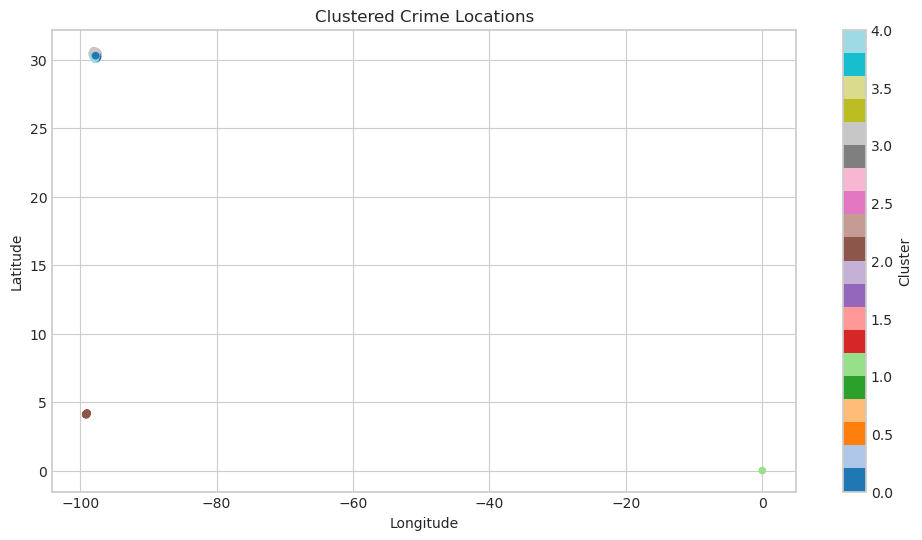

In [5]:

# Load the data
file_path = "/kaggle/input/10232023/Crime_Reports.csv"
data = load_data(file_path)

if data is not None:
    data = clean_data(data)

    # Additional data analysis and visualizations can be performed here.

    # Data Summary and Cleaning
    data_description = data.describe()

    missing_values = data.isnull().sum()

    data["Clearance Status"].fillna("Not Cleared", inplace=True)

    latitude = data.get("Latitude", 0.0)
    longitude = data.get("Longitude", 0.0)

    if "Occurred Date Time" in data.columns:
        data["Occurred Date Time"] = pd.to_datetime(data["Occurred Date Time"])
        data["Report Date Time"] = pd.to_datetime(data["Report Date Time"])
        data_types = data.dtypes

        plt.figure(figsize=(12, 6))
        data["Occurred Date Time"].value_counts().resample("M").sum().plot()
        plt.title("Monthly Crime Trends")
        plt.xlabel("Year-Month")
        plt.ylabel("Number of Crimes")

        yearly_crime_stats = data.groupby(data["Occurred Date Time"].dt.year)[
            "Category Description"
        ].count()
        monthly_crime_stats = data.groupby(
            data["Occurred Date Time"].dt.to_period("M")
        )["Category Description"].count()
    else:
        print("The 'Occurred Date Time' column is not present in the dataset.")
    # Crime Categories Analysis
    data = data[data["Category Description"] != "Unknown"]
    crime_category_counts = data["Category Description"].value_counts()

    plt.figure(figsize=(12, 6))
    sns.countplot(
        data=data, x="Category Description", order=crime_category_counts.index
    )
    plt.title("Distribution of Crime Categories")
    plt.xlabel("Category Description")
    plt.ylabel("Number of Crimes")
    plt.xticks(rotation=90)
    category_plot_file = os.path.join(OUTPUT_DIRECTORY, "crime_categories_plot.png")
    plt.savefig(category_plot_file)

    specific_category = "Murder"
    category_trends = data[data["Category Description"] == specific_category]

    crime_by_zipcode = data["Zip Code"].value_counts()

    crime_rates_by_zipcode = data["Zip Code"].value_counts(normalize=True)

    plt.figure(figsize=(12, 6))
    crime_by_zipcode.head(10).plot(kind="bar")
    plt.title("Top 10 Zip Codes with the Highest Crime Rates")
    plt.xlabel("Zip Code")
    plt.ylabel("Number of Crimes")
    zip_code_plot_file = os.path.join(OUTPUT_DIRECTORY, "top_zip_codes_plot.png")
    plt.savefig(zip_code_plot_file)

    plot_bar_graph(
        data["Category Description"].value_counts(),
        "Crime Type",
        "Total Incidents",
        "Total Property & Violent Crimes (2003-Present)",
        os.path.join(OUTPUT_DIRECTORY, "total_crimes_plot.png"),
    )

    data = calculate_distance_to_booking_office(data)
    data = cluster_crime_locations(data, n_clusters=5)

    plt.figure(figsize=(12, 6))
    plt.scatter(
        data["Longitude"],
        data["Latitude"],
        c=data["Distance to Booking Office (Miles)"],
        cmap="viridis",
        s=20,
    )
    plt.title("Crime Locations with Distance to Booking Office")
    plt.xlabel("Longitude")
    plt.ylabel("Latitude")
    plt.colorbar(label="Distance to Booking Office (Miles)")
    distance_plot_file = os.path.join(
        OUTPUT_DIRECTORY, "distance_to_booking_office_plot.png"
    )
    plt.savefig(distance_plot_file)

    plt.figure(figsize=(12, 6))
    plt.scatter(
        data["Longitude"],
        data["Latitude"],
        c=data["Location Cluster"],
        cmap="tab20",
        s=20,
    )
    plt.title("Clustered Crime Locations")
    plt.xlabel("Longitude")
    plt.ylabel("Latitude")
    plt.colorbar(label="Cluster")
    cluster_plot_file = os.path.join(OUTPUT_DIRECTORY, "clustered_locations_plot.png")
    plt.savefig(cluster_plot_file)

    crime_categories = ["Aggravated Assault", "Robbery", "Murder"]
    for category in crime_categories:
        create_heatmap(
            data[data["Category Description"] == category],
            os.path.join(
                OUTPUT_DIRECTORY, f"{category.lower().replace(' ', '_')}_heatmap.html"
            ),
        )
    # Save the output file
    output.close()
# Display plots and results
plt.show()
